In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/SW엔지니어/data

/content/drive/MyDrive/Colab Notebooks/SW엔지니어/data


# 도시 소음 데이터
- 공식 사이트 (NYU Music and Audio Research Lab)
  - https://urbansounddataset.weebly.com/urbansound8k.html
- 10개 클래스 : 에어컨, 자동차 경적, 어린이 놀이, 개 짖는 소리 등
- 도시 소음의 8732개(4초 이하)

In [ ]:
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz

--2025-06-23 06:40:59--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2025-06-23 06:40:59--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘UrbanSound8K.tar.gz’

UrbanSound8K.tar.gz 100%[===================>]   5.61G  21.5MB/s    in 5m 30s  

2025-06-23 06:46:29 (17.4 MB/s) - ‘UrbanSound8K.tar.gz’ saved [6023741708/6023741708]



In [ ]:
!mkdir -p /UrbanSound8K
!tar -xvzf UrbanSound8K.tar.gz UrbanSound8K/audio/fold1/ UrbanSound8K/audio/fold2/ UrbanSound8K/audio/fold3/ -C /UrbanSound8K

UrbanSound8K/audio/fold1/
UrbanSound8K/audio/fold1/.DS_Store
UrbanSound8K/audio/fold1/101415-3-0-2.wav
UrbanSound8K/audio/fold1/101415-3-0-3.wav
UrbanSound8K/audio/fold1/101415-3-0-8.wav
UrbanSound8K/audio/fold1/102106-3-0-0.wav
UrbanSound8K/audio/fold1/102305-6-0-0.wav
UrbanSound8K/audio/fold1/102842-3-0-1.wav
UrbanSound8K/audio/fold1/102842-3-1-0.wav
UrbanSound8K/audio/fold1/102842-3-1-5.wav
UrbanSound8K/audio/fold1/102842-3-1-6.wav
UrbanSound8K/audio/fold1/103074-7-0-0.wav
UrbanSound8K/audio/fold1/103074-7-0-1.wav
UrbanSound8K/audio/fold1/103074-7-0-2.wav
UrbanSound8K/audio/fold1/103074-7-1-0.wav
UrbanSound8K/audio/fold1/103074-7-1-1.wav
UrbanSound8K/audio/fold1/103074-7-1-2.wav
UrbanSound8K/audio/fold1/103074-7-1-3.wav
UrbanSound8K/audio/fold1/103074-7-1-4.wav
UrbanSound8K/audio/fold1/103074-7-1-5.wav
UrbanSound8K/audio/fold1/103074-7-1-6.wav
UrbanSound8K/audio/fold1/103074-7-2-0.wav
UrbanSound8K/audio/fold1/103074-7-3-0.wav
UrbanSound8K/audio/fold1/103074-7-3-1.wav
UrbanSound8K/au

In [3]:
import os
import numpy as np
import glob # 파일 시스템에서 패턴 매칭을 사용해 파일 목록을 찾는 라이브러리
import librosa # 음악 또는 오디오 처리를 위한 라이브러리

# 도시 소음 소리의 특징과 정답(label) 추출
1. 각 소리 파일을 일정한 길이로 나눔 -> 슬라이딩 윈도우
2. 각 구간 MFCC 추출
3. 파일 이름으로 부터 label 추출
4. 특징과 라벨 리스트 변환

In [4]:
# 1. 윈도우 구간을 만들어주는 generater 함수 생성

# data_length : 전체 데이터의 길이
# window_size : 자를 구간의 크기
# step_size : 윈도우를 얼만큼 이동할지

def generate_windows(data_length, window_size, step_size):
  for start in range(0, data_length - window_size +1, step_size):
    yield start, start + window_size
           # yield : 제너레이터 함수를 만들기 위해 사용

## MFCC (Mel-Frequency Cepstral Coefficients)
- 오디오 신호를 사람이 듣는 방식과 유사하게 표현한 주파수 기반 특징
- 주로 음성 인식, 환경 소리 분류 등에서 사용
- Mel : 사람의 달팽이관을 모티브로 따온 값
  - 달팽이관은 각 부분마다 다른 주파수(진동수)를 감지
  - 저주파 -> 고주파 영역으로 갈 수록 얇아짐
  - 주파수 낮으면 소리 변화 잘 감지, 높으면 감지하기 어려움

### MFCC 동작 방식
1. 프레임 분할
   - 짧은 구간으로 나눔 (일반적으로 20~40ms)
2. STFT (Short-Time Fourier Transform)
  - 각 구간 별 푸리에 변환을 수행하는 주파수 스펙트럼
  - 푸리에 변환 : 시간영역의 신호 주파수를 영역으로 분해하는 방법
3. Mel Filter Bank 적용
  - 사람의 청각 특성을 반영하여 단순 주파수 값보다 더욱 사람처럼 소리를 인식할 수 있도록 낮은 주파수는 좁은, 높은 주파수는 넓은 필터 배치
4. 로그 스케일링 (Log Scaling)
  - 멜 스펙트럼의 진폭 값으로 로그 변환
5. DCT (Discrete Cosine Transform)
  - 특징을 압축해서 표현

In [5]:
# 2. 하나의 오디오 파일에서 MFCC 특징 추출

def extract_mfcc_segments(audio, sr, bands=20, frames=41):
              # 윈도우 설정
  window_size = 512*(frames - 1)
  step_size = window_size // 2
  mfcc_segments = []

              # 오디오를 슬라이딩 윈도우로 자름
  for start, end in generate_windows(len(audio), window_size, step_size):
    segment = audio[start:end]

              # MFCC 특징 추출
              # sr : 샘플링레이트
              # bands : MFCC 계수 개수 (기본 20), 한 프레임당 20개 숫자로 그 순간 주파수 특징 표현
    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=bands)
    mfcc = mfcc.T # (time, bands) 전치

               # 원하는 프레임 수만 유지
    if mfcc.shape[0] == frames:  # 정확히 원하는 프레임 수 일 때
      mfcc_segments.append(mfcc)

               # if mfcc.shape[0] >= frames:
               #   mfcc = mfcc[:frames]  # 41개보다 많으면 잘라서 사용
               #   mfcc_segments.append(mfcc)

  return np.array(mfcc_segments) # shape: (segments, frames, bands)

# 하나의 소리(오디오)에서 짧은 구간 여러개 추출 후 각 구간에서 MFCC를 뽑아 (frames, bands)를 저장

In [6]:
# MFCC 시각화
import librosa.display
import matplotlib.pyplot as plt

/content/drive/MyDrive/Colab Notebooks/SW엔지니어/data


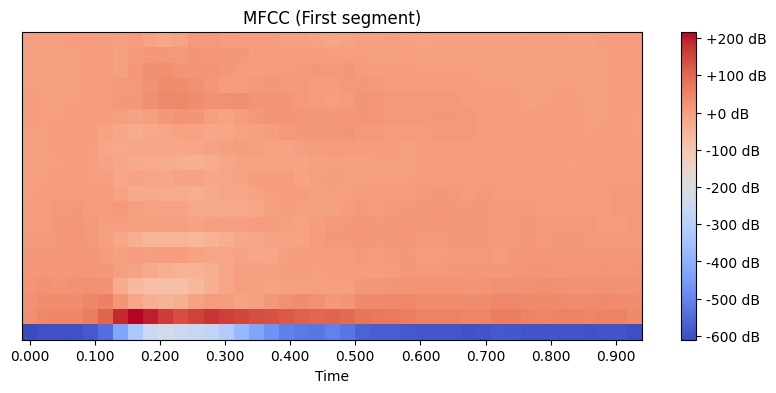

In [7]:
# 오디오 파일 가져오기 101415-3-0-2.wav
audio, sr = librosa.load("./UrbanSound8K/audio/fold1/101415-3-0-2.wav")

# MFCC 추출
mfcc_segments = extract_mfcc_segments(audio, sr)

# 시각화
plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc_segments[0].T, sr=sr, x_axis='time')
plt.colorbar(format="%+2.0f dB")
plt.title("MFCC (First segment)")
plt.show()

In [8]:
# 3. 파일 이름에서 라벨 추출 (UrbanSound8K 기준)
# 101415-3-0-2.wav -> file_name_label(class)_... wav
def get_label_from_filename(filename):
  parts = filename.split('/') # 경로를 가져와서 '/' 기준으로 쪼개기
  basename = os.path.basename(parts[-1]) # 쪼개진 문자열이 담긴 리스트에서 -1번째 인덱스가 파일명
  basename.split('-')
  label = int(basename.split('-')[1])
  return label

In [9]:
# 4. 전체 폴더에서 특징과 라벨 추출
def extract_features_from_folder(folder_path, file_ext="*.wav", bands=20, frames=41):
  all_features = []
  all_labels = []

              # glob함수 : 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
  for filepath in glob.glob(os.path.join(folder_path, file_ext)):
    try:
              # 오디오 자르고 MFCC 추출 (이전에 만든 함수 사용)
      audio, sr = librosa.load(filepath, sr=None)
              # 결과 : (segment 수, frames, bands)
      mfccs = extract_mfcc_segments(audio, sr, bands, frames)
              # 파일 이름에서 label 추출
      label = get_label_from_filename(filepath)

      if mfccs.shape[0] > 0:
        all_features.append(mfccs)
        all_labels.append([label] * len(mfccs))

    except Exception as e:
      print(f"오류 발생: {filepath}, 에러: {e}")
  return all_features, all_labels

In [10]:
all_features = []
all_labels = []

folders = ['fold1', 'fold2', 'fold3']

for fold in folders:
  folder_path = os.path.join('UrbanSound8K/audio', fold)
  features, labels = extract_features_from_folder(folder_path)
  all_features.extend(features)
  all_labels.extend(labels)

# numpy 배열로 변환
x = np.concatenate(all_features, axis=0).astype(np.float32)
y = np.concatenate(all_labels, axis=0).astype(np.int32)

In [11]:
x.shape, y.shape

((41204, 41, 20), (41204,))

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# 문제와 답 나누기
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32963, 41, 20), (8241, 41, 20), (32963,), (8241,))

### 모델링
- GRU 기반 순환 신경망

In [15]:
# 모델링 도구 가져오기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
model = Sequential() # frame 수(순환 횟수), bands(특성 수)
model.add(InputLayer(input_shape=(41, 20))) # 입력층
model.add(GRU(128, activation = 'tanh'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(10, activation='softmax')) # 출력층. 다중분류
model.compile(optimizer=Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [17]:
# 모델 학습
his = model.fit(X_train, y_train, validation_split=0.1, epochs=20, batch_size=24)

Epoch 1/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 45s 34ms/step - accuracy: 0.3604 - loss: 1.8346 - val_accuracy: 0.6175 - val_loss: 1.1638
Epoch 2/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.6567 - loss: 1.0578 - val_accuracy: 0.7522 - val_loss: 0.8265
Epoch 3/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.7634 - loss: 0.7733 - val_accuracy: 0.8053 - val_loss: 0.6494
Epoch 4/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8137 - loss: 0.6147 - val_accuracy: 0.8347 - val_loss: 0.5420
Epoch 5/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 75s 35ms/step - accuracy: 0.8358 - loss: 0.5165 - val_accuracy: 0.8565 - val_loss: 0.4721
Epoch 6/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.8603 - loss: 0.4399 - val_accuracy: 0.8717 - val_loss: 0.4197
Epoch 7/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.8768 - loss: 0.3922 - val_accuracy: 0.8826 - val_loss: 0.3903
Epoch 8/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.8876 -

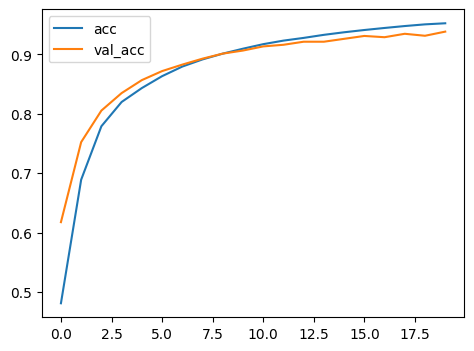

In [19]:
# 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(his.history['accuracy'], label='acc')
plt.plot(his.history['val_accuracy'], label='val_acc')
plt.legend()

In [20]:
# 예측 및 평가
from sklearn.metrics import accuracy_score
import numpy as np

In [23]:
y_pre = model.predict(X_test) # 10개의 확률값(클래스마다)
y_pre_labels = np.argmax(y_pre, axis=1) # 확률이 가장 높은 값을 이용해 라벨값만 추출
y_pre_labels

258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


array([9, 7, 2, ..., 5, 2, 9])

In [25]:
acc = accuracy_score(y_test, y_pre_labels)
print(f"정확도: {acc:.4f}")

정확도: 0.9421
